In [1]:
# Adapted from
# https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
# to work on FrozenLake environment

# imports
from __future__ import annotations
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

In [2]:
#!pip install gymnasium
#!pip install gymnasium[toy-text]

In [3]:
def init_env(_size=4):
    global env
    env = gym.make("FrozenLake-v1", is_slippery=True) # use render_mode='human' to show visualization
    global size
    size = _size

In [4]:
init_env()

In [5]:
# decode single-integer state value into (x,y) coordinates
def obs2state(n:int) -> (int,int):
    return n //size, n % size

In [ ]:
# agent, to be filled out
class FrozenLakeAgent:
    def __init__(
        self,
        learning_rate: float,
        epsilon: float,
        discount_factor: float,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            epsilon: The initial epsilon value
            discount_factor: The discount factor for computing the Q-value
        """

        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon

        self.training_error = []
        
    def get_action(self, obs: tuple[int, int]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """

        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(
        self,
        obs: tuple[int, int],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )
        # how to add to terminate if to many steps? like if above 10 steps then terminat and try again

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)
        

In [7]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
epsilon = 0.1 
discount_rate = 0.7 # value short/long term reward, high is long term focus
#start_epsilon = 1.0
#epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
#final_epsilon = 0.1

# learning
agent = FrozenLakeAgent(
    learning_rate=learning_rate,
    epsilon=epsilon,
    discount_factor=discount_rate
)

In [8]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    state = obs2state(obs)
    
    # play one episode
    while not done:
        action = agent.get_action(state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = obs2state(next_obs)
        
        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        state = obs2state(obs)

100%|██████████| 100000/100000 [00:56<00:00, 1758.83it/s]


In [9]:
def draw_plot(env, agent):
    rolling_length = int(0.005 * n_episodes)
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        np.convolve(
            np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    axs[1].set_title("Episode lengths")
    length_moving_average = (
        np.convolve(
            np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    axs[2].set_title("Training Error")
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.show()

In [10]:
def create_grids(agent, size):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    action_names = ['←', '↓', '→', ' ↑']
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))
        
    y,x = np.meshgrid(
        np.arange(0,size),
        np.arange(0,size),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([x,y]),
    )
    value_grid = x,y, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1])],
        axis=2,
        arr=np.dstack([x,y]),
    )
    
    annot_grid = np.apply_along_axis(
        lambda obs: action_names[policy[(obs[0], obs[1])]],
        axis=2,
        arr=np.dstack([x,y]),
    )
    return value_grid, policy_grid, annot_grid


def create_plots(value_grid, policy_grid, annot_grid, size, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    x,y, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        x,
        y,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(0,size), range(0,size))
    plt.yticks(range(0,size), range(0,size))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=annot_grid, fmt="s", cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_xticklabels(range(0,size))
    ax2.set_yticklabels(range(0,size))

    return fig

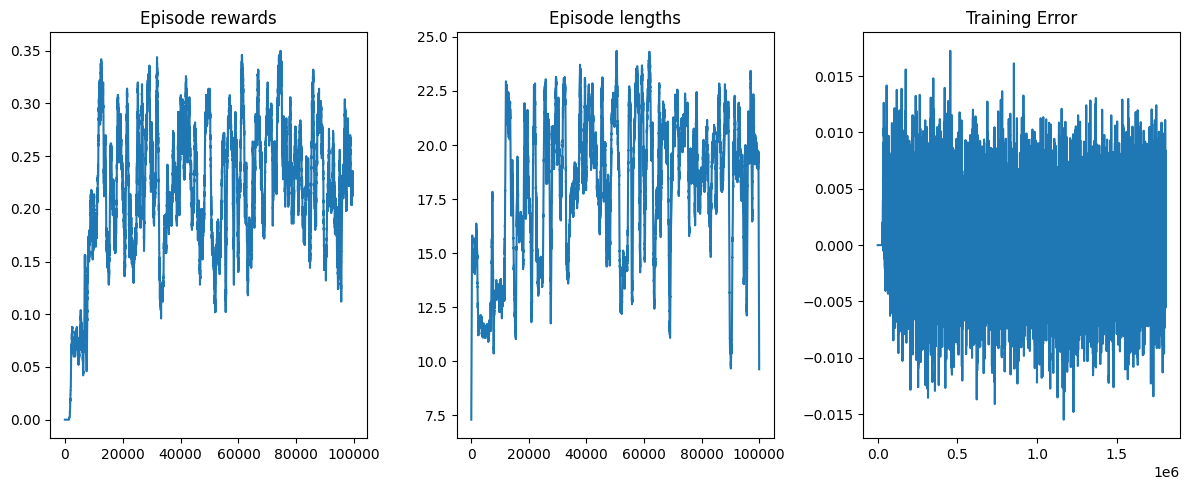

In [11]:
draw_plot(env, agent)

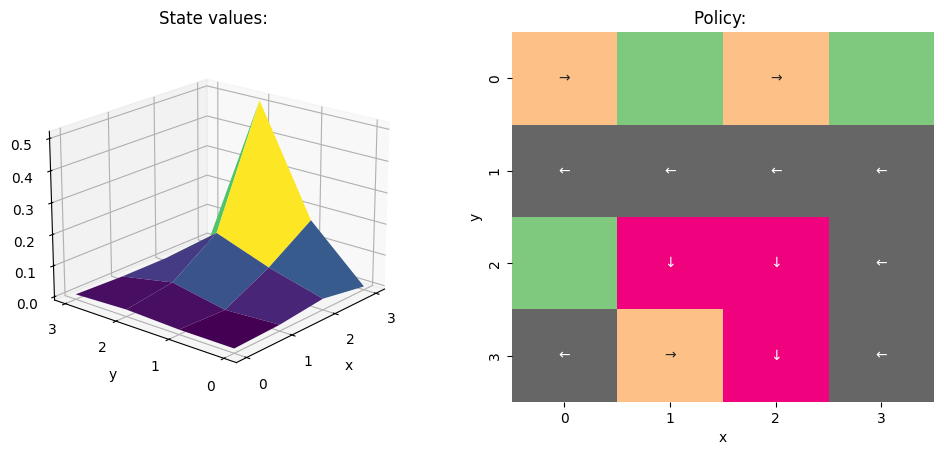

In [12]:
value_grid, policy_grid, annot_grid = create_grids(agent, size)
fig1 = create_plots(value_grid, policy_grid, annot_grid, size, title="")
plt.show()

In [13]:
init_env()

In [14]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
epsilon = 0.1 
discount_rate = 0.95 # value short/long term reward, high is long term focus
#start_epsilon = 1.0
#epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
#final_epsilon = 0.1

# learning
agent = FrozenLakeAgent(
    learning_rate=learning_rate,
    epsilon=epsilon,
    discount_factor=discount_rate
)

In [15]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    state = obs2state(obs)
    
    # play one episode
    while not done:
        action = agent.get_action(state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = obs2state(next_obs)
        
        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        state = obs2state(obs)

100%|██████████| 100000/100000 [01:18<00:00, 1281.37it/s]


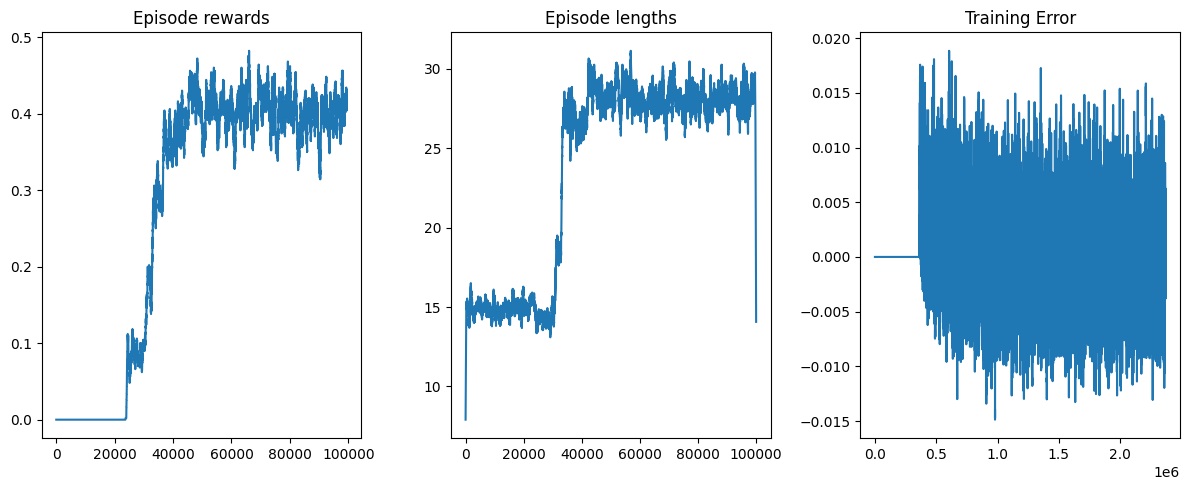

In [16]:
draw_plot(env, agent)

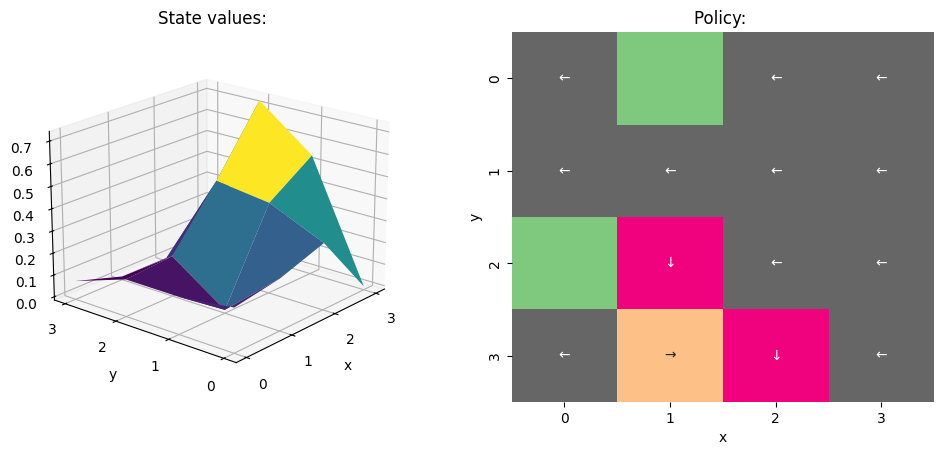

In [17]:
value_grid, policy_grid, annot_grid = create_grids(agent, size)
fig1 = create_plots(value_grid, policy_grid, annot_grid, size, title="")
plt.show()

In [23]:
init_env()

In [24]:
# hyperparameters
learning_rate = 0.02
n_episodes = 100_000
epsilon = 0.1 
discount_rate = 0.95 # value short/long term reward, high is long term focus
#start_epsilon = 1.0
#epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
#final_epsilon = 0.1

# learning
agent = FrozenLakeAgent(
    learning_rate=learning_rate,
    epsilon=epsilon,
    discount_factor=discount_rate
)

In [25]:
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    state = obs2state(obs)
    
    # play one episode
    while not done:
        action = agent.get_action(state)
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_state = obs2state(next_obs)
        
        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs
        state = obs2state(obs)

100%|██████████| 100000/100000 [01:25<00:00, 1174.93it/s]


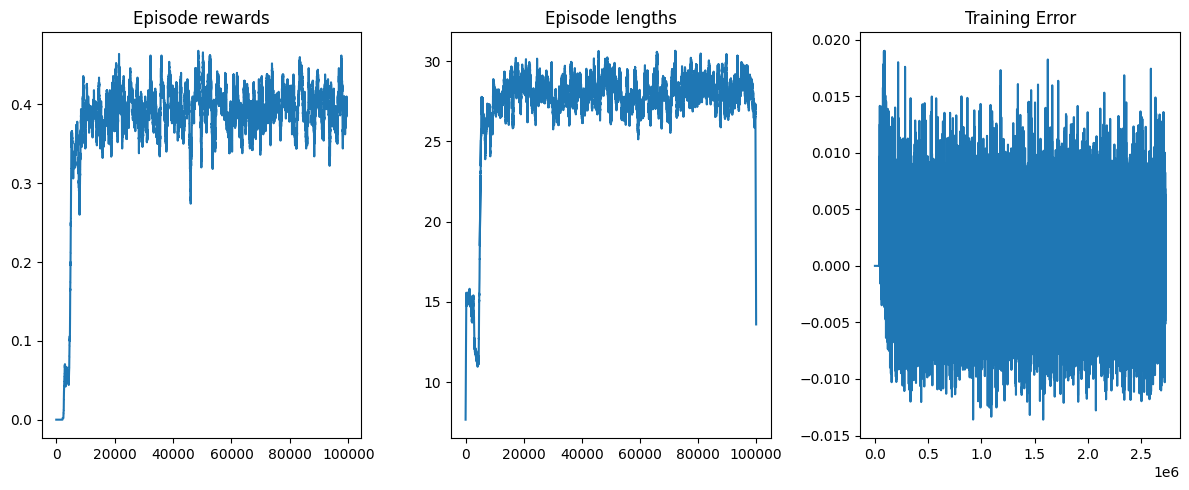

In [26]:
draw_plot(env, agent)

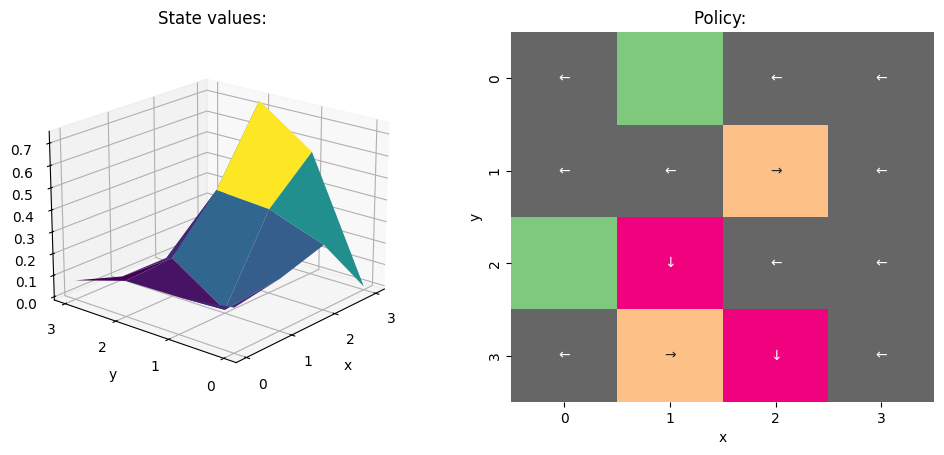

In [27]:
value_grid, policy_grid, annot_grid = create_grids(agent, size)
fig1 = create_plots(value_grid, policy_grid, annot_grid, size, title="")
plt.show()